In [1]:
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

# Define the model architecture
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)

# Load the weights from the .bin file
weights_path = '/home/jovyan/sentiment/all_models/XLM_sentiment_model.bin'  # Update with the correct path to your .bin file
model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))

# Save the complete model (including config)
model_save_path = 'XLM_ROBERTA_CASED'
model.save_pretrained(model_save_path)

# Also save the tokenizer (assuming it's the same as used in training)
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
tokenizer.save_pretrained(model_save_path)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('XLM_ROBERTA_CASED/tokenizer_config.json',
 'XLM_ROBERTA_CASED/special_tokens_map.json',
 'XLM_ROBERTA_CASED/sentencepiece.bpe.model',
 'XLM_ROBERTA_CASED/added_tokens.json')

In [4]:
import torch
import pandas as pd
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re

# Function to remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# Function to normalize text
def normalize_text(text):
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    text = text.replace('ۀ', 'ہ').replace('ۂ', 'ہ').replace('ؤ', 'و').replace('ئ', 'ی')
    return text

# Custom Dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load the tokenizer and model from the directory
model_dir = '/home/jovyan/sentiment/XLM_ROBERTA_CASED'  # Directory containing config and model weights
tokenizer = XLMRobertaTokenizer.from_pretrained(model_dir)
model = XLMRobertaForSequenceClassification.from_pretrained(model_dir)
model.eval()

# Device configuration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Load and preprocess the test dataset
test_data = pd.read_csv('/home/jovyan/sentiment/test_dataset.csv')  # Update with the correct path to your test dataset
test_data['Tweets'] = test_data['Tweets'].apply(remove_html_tags).apply(normalize_text)

# Define the test dataset and DataLoader
MAX_LEN = 128
BATCH_SIZE = 16
test_dataset = TweetDataset(test_data['Tweets'].tolist(), test_data['label'].tolist(), tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluation function
def eval_model(model, data_loader, device):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    
    return accuracy, precision, recall, f1

# Evaluate the model on the test set
accuracy, precision, recall, f1 = eval_model(model, test_loader, device)

print(f'Accuracy: {accuracy:.7f}')
print(f'Precision: {precision:.7f}')
print(f'Recall: {recall:.7f}')
print(f'F1 Score: {f1:.7f}')


Accuracy: 0.7951371
Precision: 0.7991728
Recall: 0.7951371
F1 Score: 0.7947472


In [2]:
import pandas as pd
import re

# Install necessary packages
!pip install transformers pandas torch nltk matplotlib numpy joblib

# Import the installed packages
import nltk

# Data visualization (optional, for visualizing data distributions)
import matplotlib.pyplot as plt

# Numpy (optional, for numerical operations)
import numpy as np

# String module (optional, for additional string operations)
import string

In [3]:
!pip install sentencepiece


  Using cached sentencepiece-0.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)


In [6]:
import pandas as pd
import re
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np

# Install SentencePiece if not already installed
try:
    import sentencepiece
except ImportError:
    # You might need to restart your runtime or kernel after this installation
    !pip install sentencepiece
    import sentencepiece

# Custom list of Urdu stopwords
urdu_stopwords = set([
    'اور', 'کے', 'میں', 'سے', 'کو', 'پر', 'ہے', 'کی', 'کہ', 'یہ', 'جو', 'بھی', 'کا', 'نے', 'گا', 'کر',
    'ہیں', 'ایک', 'سب', 'تو', 'وہ', 'تم', 'جب', 'ہم', 'یا', 'نہیں', 'وہاں', 'تھا', 'تھی', 'تھے', 'اگر',
    'یہاں', 'ہوں', 'رہا', 'گئی', 'تھا', 'تھی', 'تھے'
])

# Load the dataset
data = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

In [8]:
# Check the distribution of sentiment labels (assuming they are 0 and 1)
print(data['label'].value_counts())

1    3896
0    3772
Name: label, dtype: int64


In [9]:
# Remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

data['Tweets'] = data['Tweets'].apply(remove_html_tags)

# Handle missing values and remove duplicates
data.dropna(subset=['Tweets'], inplace=True)
data.drop_duplicates(subset=['Tweets'], inplace=True)

# Normalize text
def normalize_text(text):
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    text = text.replace('ۀ', 'ہ').replace('ۂ', 'ہ').replace('ؤ', 'و').replace('ئ', 'ی')
    return text

data['Tweets'] = data['Tweets'].apply(normalize_text)

# Remove stop words using the custom list of Urdu stopwords
data['cleaned_text'] = data['Tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in urdu_stopwords]))

# Split the dataset into train and validation sets (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], test_size=0.2, random_state=42)

# Initialize the tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 1e-5

# Create DataLoader
train_dataset = TweetDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
val_dataset = TweetDataset(X_test.tolist(), y_test.tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

# Define train_epoch and eval_model functions here...
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    
    return accuracy, precision, recall, f1, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_dataset)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_precision, val_recall, val_f1, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_dataset)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc} precision {val_precision} recall {val_recall} f1 {val_f1}')
    print()


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5
----------
Train loss 0.682436540995192 accuracy 0.552416721097322
Val   loss 0.6901507762571176 accuracy 0.5264532984977139 precision 0.5202388852023888 recall 0.9974554707379135 f1 0.6838203227213259

Epoch 2/5
----------
Train loss 0.5966615284703107 accuracy 0.6799477465708688
Val   loss 0.5386398529323438 accuracy 0.760287393860222 precision 0.7971631205673759 recall 0.7150127226463104 f1 0.7538564721663312

Epoch 3/5
----------
Train loss 0.49230184793161036 accuracy 0.7673089483997387
Val   loss 0.48164623339350027 accuracy 0.7726975832789027 precision 0.7422566371681416 recall 0.8536895674300254 f1 0.7940828402366865

Epoch 4/5
----------
Train loss 0.42798844602338326 accuracy 0.8053559764859569
Val   loss 0.45902492400879663 accuracy 0.7766165904637492 precision 0.7788944723618091 recall 0.7888040712468194 f1 0.783817951959545

Epoch 5/5
----------
Train loss 0.38567135809840486 accuracy 0.8329523187459177
Val   loss 0.49354996252804995 accuracy 0.7805355976485957 p

In [10]:
import os

# Create a directory to save the model and tokenizer
output_dir = './model_save/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the model
model_save_path = os.path.join(output_dir, 'XLM_sentiment_model.bin')
torch.save(model.state_dict(), model_save_path)

# Save the tokenizer
tokenizer_save_path = os.path.join(output_dir, 'tokenizer/')
tokenizer.save_pretrained(tokenizer_save_path)

print("Model and tokenizer saved.")

Model and tokenizer saved.


In [4]:
import pandas as pd
import re
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np

# Install SentencePiece if not already installed
try:
    import sentencepiece
except ImportError:
    # You might need to restart your runtime or kernel after this installation
    !pip install sentencepiece
    import sentencepiece

# Custom list of Urdu stopwords
urdu_stopwords = set([
    'اور', 'کے', 'میں', 'سے', 'کو', 'پر', 'ہے', 'کی', 'کہ', 'یہ', 'جو', 'بھی', 'کا', 'نے', 'گا', 'کر',
    'ہیں', 'ایک', 'سب', 'تو', 'وہ', 'تم', 'جب', 'ہم', 'یا', 'نہیں', 'وہاں', 'تھا', 'تھی', 'تھے', 'اگر',
    'یہاں', 'ہوں', 'رہا', 'گئی', 'تھا', 'تھی', 'تھے'
])

# Load the dataset
data = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

data['Tweets'] = data['Tweets'].apply(remove_html_tags)

# Handle missing values and remove duplicates
data.dropna(subset=['Tweets'], inplace=True)
data.drop_duplicates(subset=['Tweets'], inplace=True)

# Normalize text
def normalize_text(text):
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    text = text.replace('ۀ', 'ہ').replace('ۂ', 'ہ').replace('ؤ', 'و').replace('ئ', 'ی')
    return text

data['Tweets'] = data['Tweets'].apply(normalize_text)

# Remove stop words using the custom list of Urdu stopwords
data['cleaned_text'] = data['Tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in urdu_stopwords]))

# Split the dataset into train and validation sets (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], test_size=0.2, random_state=42)

# Initialize the tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5

# Create DataLoader
train_dataset = TweetDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
val_dataset = TweetDataset(X_test.tolist(), y_test.tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

# Define train_epoch and eval_model functions here...
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    
    return accuracy, precision, recall, f1, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_dataset)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_precision, val_recall, val_f1, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_dataset)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc} precision {val_precision} recall {val_recall} f1 {val_f1}')
    print()


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5
----------
Train loss 0.6961027327779068 accuracy 0.4937949052906597
Val   loss 0.6929126884788275 accuracy 0.5133899412148922 precision 0.5133899412148922 recall 1.0 f1 0.6784635304272766

Epoch 2/5
----------
Train loss 0.6952985646519275 accuracy 0.5047354670150229
Val   loss 0.6940033740053574 accuracy 0.5133899412148922 precision 0.5133899412148922 recall 1.0 f1 0.6784635304272766

Epoch 3/5
----------
Train loss 0.6951735541029948 accuracy 0.5031025473546702
Val   loss 0.6929468779514233 accuracy 0.5133899412148922 precision 0.5133899412148922 recall 1.0 f1 0.6784635304272766

Epoch 4/5
----------
Train loss 0.6943979221286724 accuracy 0.5034291312867407


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val   loss 0.6932986707737049 accuracy 0.48661005878510777 precision 0.0 recall 0.0 f1 0.0

Epoch 5/5
----------
Train loss 0.6946389258063493 accuracy 0.4960809928151535
Val   loss 0.6930377092212439 accuracy 0.5133899412148922 precision 0.5133899412148922 recall 1.0 f1 0.6784635304272766



In [ ]:
# Save the model after training
model_save_path = "XLMRoberta_model_final.bin"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

In [17]:
!pip install transformers pandas torch

In [8]:
!pip install sentencepiece


In [4]:
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
import pandas as pd
import numpy as np

# Install SentencePiece if not already installed
try:
    import sentencepiece
except ImportError:
    !pip install sentencepiece
    import sentencepiece

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Load the pre-trained XLM-Roberta model and tokenizer
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 1e-5

# Split the dataset into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Tweets'], df['label'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset index to avoid KeyError issues
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')

    # Evaluate on test data after each epoch
    test_acc, test_loss = eval_model(
        model,
        test_loader,
        loss_fn,
        device,
        len(test_texts)
    )

    print(f'Test  loss {test_loss} accuracy {test_acc}')
    print()

# Save the trained model and tokenizer
model.save_pretrained('Trained_model_for_xlm_roberta')
tokenizer.save_pretrained('tokenizer_roberta')


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/15
----------
Train loss 0.6938349959396181 accuracy 0.514253773057574
Val   loss 0.67921874506606 accuracy 0.5539130434782609
Test  loss 0.6629457730385993 accuracy 0.5942658557775847

Epoch 2/15
----------
Train loss 0.5742224517854906 accuracy 0.7093348239239798
Val   loss 0.5270189152409633 accuracy 0.7634782608695653
Test  loss 0.5317928056336112 accuracy 0.7471763683753258

Epoch 3/15
----------
Train loss 0.4562315695608656 accuracy 0.786286566051798
Val   loss 0.4867480362041129 accuracy 0.7565217391304349
Test  loss 0.4735228373772568 accuracy 0.7628149435273675

Epoch 4/15
----------
Train loss 0.3719366756046102 accuracy 0.8378982671883733
Val   loss 0.5496591091569927 accuracy 0.78
Test  loss 0.5592398533804549 accuracy 0.7628149435273675

Epoch 5/15
----------
Train loss 0.2936292740161575 accuracy 0.8800074529532327
Val   loss 0.5619911049596138 accuracy 0.7626086956521739
Test  loss 0.5596930595735709 accuracy 0.7628149435273675

Epoch 6/15
----------
Train loss 

('tokenizer_roberta/tokenizer_config.json',
 'tokenizer_roberta/special_tokens_map.json',
 'tokenizer_roberta/sentencepiece.bpe.model',
 'tokenizer_roberta/added_tokens.json')

In [5]:
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the trained model and tokenizer
model_path = '/home/jovyan/sentiment/Trained_model_for_xlm_roberta'
tokenizer_path = '/home/jovyan/sentiment/tokenizer_roberta'

model = XLMRobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = XLMRobertaTokenizer.from_pretrained(tokenizer_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16

# Split the dataset into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Tweets'], df['label'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset index to avoid KeyError issues
test_texts = test_texts.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create DataLoader for the test dataset
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Evaluate on test data
test_acc, test_loss = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_texts)
)

print(f'Test loss {test_loss} accuracy {test_acc}')


Test loss 1.085455212328169 accuracy 0.7584708948740225


In [6]:
import pandas as pd

# Data from training process
data = {
    'Epoch': list(range(1, 16)),
    'Train Loss': [0.6938349959396181, 0.5742224517854906, 0.4562315695608656, 0.3719366756046102, 0.2936292740161575, 0.22187833151491804, 0.1652198645086693, 0.11912772306684583, 0.09973079853114628, 0.07665802081880559, 0.0682662235991475, 0.056206982580035744, 0.046001620209565205, 0.0426237826697096, 0.038128240464998055],
    'Train Accuracy': [0.514253773057574, 0.7093348239239798, 0.786286566051798, 0.8378982671883733, 0.8800074529532327, 0.9150363331470095, 0.9405626979690702, 0.9612446431898639, 0.9683249487609465, 0.9765231973169368, 0.9800633501024781, 0.9847214458729271, 0.9884479224892864, 0.990124836966648, 0.9918017514440096],
    'Val Loss': [0.67921874506606, 0.5270189152409633, 0.4867480362041129, 0.5496591091569927, 0.5619911049596138, 0.6810342909561263, 0.6896412493661046, 0.7953595663938258, 0.8062654735727443, 0.9143596676488718, 0.94978888415628, 0.963377469115787, 1.046894824028843, 1.0355335240148835, 1.052540783977343],
    'Val Accuracy': [0.5539130434782609, 0.7634782608695653, 0.7565217391304349, 0.78, 0.7626086956521739, 0.7756521739130435, 0.7643478260869565, 0.7773913043478261, 0.773913043478261, 0.773913043478261, 0.773913043478261, 0.7747826086956522, 0.773913043478261, 0.7817391304347826, 0.7765217391304348]
}

df = pd.DataFrame(data)
print(df)


    Epoch  Train Loss  Train Accuracy  Val Loss  Val Accuracy
0       1    0.693835        0.514254  0.679219      0.553913
1       2    0.574222        0.709335  0.527019      0.763478
2       3    0.456232        0.786287  0.486748      0.756522
3       4    0.371937        0.837898  0.549659      0.780000
4       5    0.293629        0.880007  0.561991      0.762609
5       6    0.221878        0.915036  0.681034      0.775652
6       7    0.165220        0.940563  0.689641      0.764348
7       8    0.119128        0.961245  0.795360      0.777391
8       9    0.099731        0.968325  0.806265      0.773913
9      10    0.076658        0.976523  0.914360      0.773913
10     11    0.068266        0.980063  0.949789      0.773913
11     12    0.056207        0.984721  0.963377      0.774783
12     13    0.046002        0.988448  1.046895      0.773913
13     14    0.042624        0.990125  1.035534      0.781739
14     15    0.038128        0.991802  1.052541      0.776522


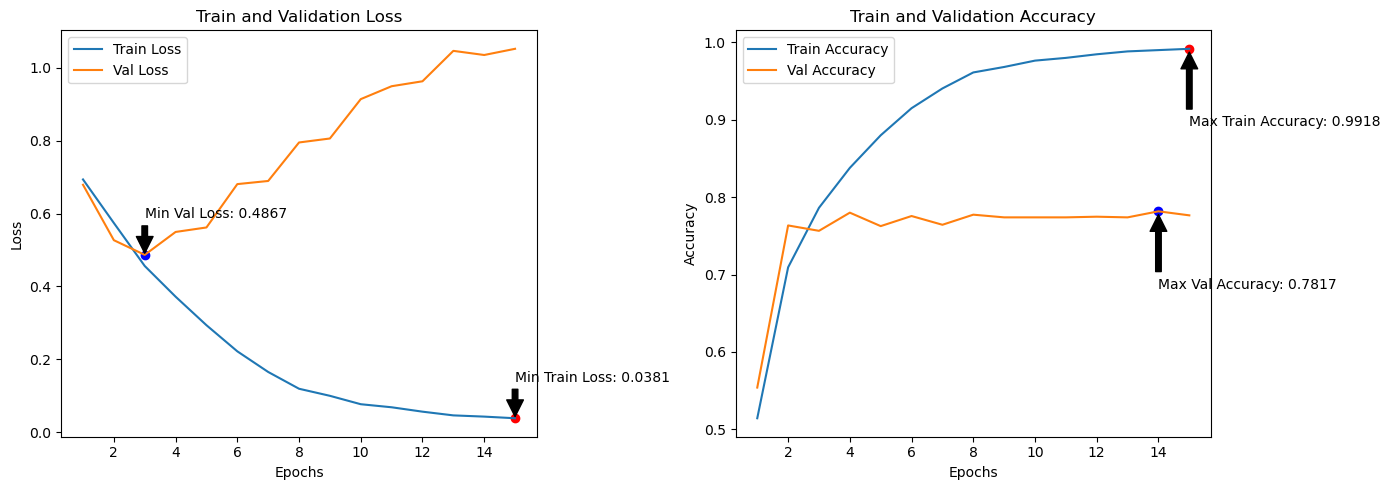

In [7]:
import matplotlib.pyplot as plt

# Plot Train Loss and Validation Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(df['Epoch'], df['Train Loss'], label='Train Loss')
plt.plot(df['Epoch'], df['Val Loss'], label='Val Loss')
plt.scatter(df['Epoch'][df['Train Loss'].idxmin()], df['Train Loss'].min(), color='red') # Min Train Loss
plt.scatter(df['Epoch'][df['Val Loss'].idxmin()], df['Val Loss'].min(), color='blue') # Min Val Loss
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(f'Min Train Loss: {df["Train Loss"].min():.4f}', xy=(df['Epoch'][df['Train Loss'].idxmin()], df['Train Loss'].min()), xytext=(df['Epoch'][df['Train Loss'].idxmin()], df['Train Loss'].min()+0.1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Min Val Loss: {df["Val Loss"].min():.4f}', xy=(df['Epoch'][df['Val Loss'].idxmin()], df['Val Loss'].min()), xytext=(df['Epoch'][df['Val Loss'].idxmin()], df['Val Loss'].min()+0.1), arrowprops=dict(facecolor='black', shrink=0.05))

# Plot Train Accuracy and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['Epoch'], df['Train Accuracy'], label='Train Accuracy')
plt.plot(df['Epoch'], df['Val Accuracy'], label='Val Accuracy')
plt.scatter(df['Epoch'][df['Train Accuracy'].idxmax()], df['Train Accuracy'].max(), color='red') # Max Train Accuracy
plt.scatter(df['Epoch'][df['Val Accuracy'].idxmax()], df['Val Accuracy'].max(), color='blue') # Max Val Accuracy
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate(f'Max Train Accuracy: {df["Train Accuracy"].max():.4f}', xy=(df['Epoch'][df['Train Accuracy'].idxmax()], df['Train Accuracy'].max()), xytext=(df['Epoch'][df['Train Accuracy'].idxmax()], df['Train Accuracy'].max()-0.1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Max Val Accuracy: {df["Val Accuracy"].max():.4f}', xy=(df['Epoch'][df['Val Accuracy'].idxmax()], df['Val Accuracy'].max()), xytext=(df['Epoch'][df['Val Accuracy'].idxmax()], df['Val Accuracy'].max()-0.1), arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()


In [4]:
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np

# Install SentencePiece if not already installed
try:
    import sentencepiece
except ImportError:
    !pip install sentencepiece
    import sentencepiece

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Load the pre-trained XLM-Roberta model and tokenizer
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 20  # Increased number of epochs
LEARNING_RATE = 2e-5  # Experiment with a different learning rate

# Split the dataset into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Tweets'], df['label'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset index to avoid KeyError issues
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')

    # Evaluate on test data after each epoch
    test_acc, test_loss = eval_model(
        model,
        test_loader,
        loss_fn,
        device,
        len(test_texts)
    )

    print(f'Test  loss {test_loss} accuracy {test_acc}')
    print()

# Save the trained model and tokenizer
model.save_pretrained('Trained_model_for_xlm_roberta')
tokenizer.save_pretrained('tokenizer_roberta')


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
----------
Train loss 0.693179772545894 accuracy 0.5248742314141979
Val   loss 0.6636092282003827 accuracy 0.6991304347826087
Test  loss 0.6582788220710225 accuracy 0.7115551694178974

Epoch 2/20
----------
Train loss 0.6280388738073054 accuracy 0.6607043040804919
Val   loss 0.5522181801497936 accuracy 0.6991304347826087
Test  loss 0.552462009092172 accuracy 0.7002606429192006

Epoch 3/20
----------
Train loss 0.5238890492667755 accuracy 0.7484628283957518
Val   loss 0.5079478315181203 accuracy 0.7321739130434783
Test  loss 0.5288199029035039 accuracy 0.7089487402258905

Epoch 4/20
----------
Train loss 0.4467041584485698 accuracy 0.805664244456866
Val   loss 0.4704939994133181 accuracy 0.7860869565217392
Test  loss 0.4889984679304891 accuracy 0.7758470894874022

Epoch 5/20
----------
Train loss 0.3517152577017744 accuracy 0.8576485932550773
Val   loss 0.5034379454122649 accuracy 0.7843478260869565
Test  loss 0.543460239449309 accuracy 0.7593397046046916

Epoch 6/20
--------

KeyboardInterrupt: 

In [19]:
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np

# Install SentencePiece if not already installed
try:
    import sentencepiece
except ImportError:
    !pip install sentencepiece
    import sentencepiece

# Load the training/validation dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Load the pre-trained XLM-Roberta model and tokenizer
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 15  # Increased number of epochs
LEARNING_RATE = 1e-5  # Experiment with a different learning rate

# Split the dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Tweets'], df['label'], test_size=0.2, random_state=42)

# Reset index to avoid KeyError issues
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')

# Save the trained model and tokenizer
model.save_pretrained('xlm_roberta')
tokenizer.save_pretrained('new_tokenizer_roberta')


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/15
----------
Train loss 0.6875362697367867 accuracy 0.5427127486142811
Val   loss 0.615106076002121 accuracy 0.6883963494132985
Epoch 2/15
----------
Train loss 0.5834171084376673 accuracy 0.7076948157808933
Val   loss 0.4904790630874534 accuracy 0.7666232073011734
Epoch 3/15
----------
Train loss 0.4524518313507239 accuracy 0.7952396478643625
Val   loss 0.4863950641204913 accuracy 0.772490221642764
Epoch 4/15
----------
Train loss 0.370227088589066 accuracy 0.8439843495272253
Val   loss 0.4910891615630438 accuracy 0.7900912646675359
Epoch 5/15
----------
Train loss 0.2951183402716803 accuracy 0.881154222367134
Val   loss 0.4970789106252293 accuracy 0.7940026075619295
Epoch 6/15
----------
Train loss 0.21746058956099054 accuracy 0.9215846103684382
Val   loss 0.6569169124704786 accuracy 0.78748370273794
Epoch 7/15
----------
Train loss 0.17621038878375353 accuracy 0.941310727094881
Val   loss 0.6362665991376465 accuracy 0.7855280312907431
Epoch 8/15
----------
Train loss 0.1320

('new_tokenizer_roberta/tokenizer_config.json',
 'new_tokenizer_roberta/special_tokens_map.json',
 'new_tokenizer_roberta/sentencepiece.bpe.model',
 'new_tokenizer_roberta/added_tokens.json')

In [7]:
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np

# Install SentencePiece if not already installed
try:
    import sentencepiece
except ImportError:
    !pip install sentencepiece
    import sentencepiece

# Load the training/validation dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Load the pre-trained XLM-Roberta model and tokenizer
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-5  # Lower learning rate

# Split the dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Tweets'], df['label'], test_size=0.2, random_state=42)

# Reset index to avoid KeyError issues
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer and scheduler with weight decay for regularization
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.2 * total_steps), num_training_steps=total_steps)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

# Implement early stopping
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.best_score = -val_loss

early_stopping = EarlyStopping(patience=5, verbose=True)  # Increased patience

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop with early stopping
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Save the best model and tokenizer
model.load_state_dict(torch.load('checkpoint.pt'))
model.save_pretrained('xlm_roberta')
tokenizer.save_pretrained('new_tokenizer_roberta')


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
----------
Train loss 0.6762628452076266 accuracy 0.5655363547440495
Val   loss 0.5935744661837816 accuracy 0.7294654498044328
Validation loss decreased (-0.593574 --> 0.593574).  Saving model ...
Epoch 2/20
----------
Train loss 0.5391978015347073 accuracy 0.7394848386044995
Val   loss 0.45610198720047873 accuracy 0.7842242503259452
Validation loss decreased (-0.456102 --> 0.456102).  Saving model ...
Epoch 3/20
----------
Train loss 0.4656481410687168 accuracy 0.7896967720899902
Val   loss 0.47997938725166023 accuracy 0.771186440677966
Epoch 4/20
----------
Train loss 0.3955772038898431 accuracy 0.8271926964460384
Val   loss 0.45221171745409566 accuracy 0.78748370273794
Validation loss decreased (-0.452212 --> 0.452212).  Saving model ...
Epoch 5/20
----------
Train loss 0.34159373481331085 accuracy 0.8576785132050864
Val   loss 0.49454298328297835 accuracy 0.7998696219035202
Epoch 6/20
----------
Train loss 0.25791622092947364 accuracy 0.8987610042386697
Val   loss 0.5526

('new_tokenizer_roberta/tokenizer_config.json',
 'new_tokenizer_roberta/special_tokens_map.json',
 'new_tokenizer_roberta/sentencepiece.bpe.model',
 'new_tokenizer_roberta/added_tokens.json')

In [8]:
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np

# Install SentencePiece if not already installed
try:
    import sentencepiece
except ImportError:
    !pip install sentencepiece
    import sentencepiece

# Load the training/validation dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Load the pre-trained XLM-Roberta model and tokenizer
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-5  # Lower learning rate

# Split the dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Tweets'], df['label'], test_size=0.2, random_state=42)

# Reset index to avoid KeyError issues
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer and scheduler with weight decay for regularization
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

# Implement early stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.best_score = -val_loss

early_stopping = EarlyStopping(patience=5, verbose=True)  # Increased patience

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop with early stopping
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Save the best model and tokenizer
model.load_state_dict(torch.load('checkpoint.pt'))
model.save_pretrained('xlm_roberta')
tokenizer.save_pretrained('new_tokenizer_roberta')


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
----------
Train loss 0.6791795318325361 accuracy 0.5567329638082817
Val   loss 0.6935139863441387 accuracy 0.5136897001303781
Validation loss decreased (-0.693514 --> 0.693514).  Saving model ...
Epoch 2/20
----------
Train loss 0.6377022115048021 accuracy 0.6230844473426801
Val   loss 0.6049201004207134 accuracy 0.741199478487614
Validation loss decreased (-0.604920 --> 0.604920).  Saving model ...
Epoch 3/20
----------
Train loss 0.5199446603267764 accuracy 0.7626344962504076
Val   loss 0.4651030969495575 accuracy 0.7842242503259452
Validation loss decreased (-0.465103 --> 0.465103).  Saving model ...
Epoch 4/20
----------
Train loss 0.4229202870434771 accuracy 0.8112161721552005
Val   loss 0.45348299589628976 accuracy 0.7940026075619295
Validation loss decreased (-0.453483 --> 0.453483).  Saving model ...
Epoch 5/20
----------
Train loss 0.34719072920658317 accuracy 0.8555591783501794
Val   loss 0.4980365901719779 accuracy 0.7998696219035202
Epoch 6/20
----------
Train l

('new_tokenizer_roberta/tokenizer_config.json',
 'new_tokenizer_roberta/special_tokens_map.json',
 'new_tokenizer_roberta/sentencepiece.bpe.model',
 'new_tokenizer_roberta/added_tokens.json')

In [9]:
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np

# Install SentencePiece if not already installed
try:
    import sentencepiece
except ImportError:
    !pip install sentencepiece
    import sentencepiece

# Load the training/validation dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Load the pre-trained XLM-Roberta model and tokenizer
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Freeze all layers except the last layer for initial training
for param in model.base_model.parameters():
    param.requires_grad = False

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-5  # Lower learning rate

# Split the dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Tweets'], df['label'], test_size=0.2, random_state=42)

# Reset index to avoid KeyError issues
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer and scheduler with weight decay for regularization
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

# Implement early stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.best_score = -val_loss

early_stopping = EarlyStopping(patience=5, verbose=True)  # Increased patience

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop with early stopping
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Unfreeze all layers for fine-tuning
for param in model.base_model.parameters():
    param.requires_grad = True

# Reinitialize optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)

# Continue training loop with all layers unfrozen
for epoch in range(EPOCHS):
    print(f'Fine-tuning Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Save the best model and tokenizer
model.load_state_dict(torch.load('checkpoint.pt'))
model.save_pretrained('xlm_roberta')
tokenizer.save_pretrained('new_tokenizer_roberta')


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
----------
Train loss 0.6948345823523899 accuracy 0.4954352787740463
Val   loss 0.6931092186520497 accuracy 0.48565840938722293
Validation loss decreased (-0.693109 --> 0.693109).  Saving model ...
Epoch 2/20
----------
Train loss 0.6934302334363261 accuracy 0.5097815454841865
Val   loss 0.6929606329649687 accuracy 0.4863102998696219
Validation loss decreased (-0.692961 --> 0.692961).  Saving model ...
Epoch 3/20
----------
Train loss 0.6931467914643387 accuracy 0.5138571894359308
Val   loss 0.6912582032382488 accuracy 0.651238591916558
Validation loss decreased (-0.691258 --> 0.691258).  Saving model ...
Epoch 4/20
----------
Train loss 0.6931785857304931 accuracy 0.5140202151940007
Val   loss 0.6902290042489767 accuracy 0.5215123859191656
Validation loss decreased (-0.690229 --> 0.690229).  Saving model ...
Epoch 5/20
----------
Train loss 0.6902727408645054 accuracy 0.5358656667753505
Val   loss 0.689536559705933 accuracy 0.5136897001303781
Validation loss decreased (-0.6

('new_tokenizer_roberta/tokenizer_config.json',
 'new_tokenizer_roberta/special_tokens_map.json',
 'new_tokenizer_roberta/sentencepiece.bpe.model',
 'new_tokenizer_roberta/added_tokens.json')

In [12]:
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

# Install SentencePiece if not already installed
try:
    import sentencepiece
except ImportError:
    !pip install sentencepiece
    import sentencepiece

# Load the training/validation dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Load the pre-trained XLM-Roberta model and tokenizer
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Freeze all layers except the last layer for initial training
for param in model.base_model.parameters():
    param.requires_grad = False

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-5  # Initial learning rate

# Split the dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Tweets'], df['label'], test_size=0.2, random_state=42)

# Reset index to avoid KeyError issues
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer and scheduler with weight decay for regularization
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

# Implement early stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.best_score = -val_loss

early_stopping = EarlyStopping(patience=5, verbose=True)  # Increased patience

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler=None, n_examples=0):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop with early stopping
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Unfreeze all layers for fine-tuning
for param in model.base_model.parameters():
    param.requires_grad = True

# Reinitialize optimizer and scheduler with a lower learning rate for fine-tuning
fine_tuning_lr = 5e-6
optimizer = AdamW(model.parameters(), lr=fine_tuning_lr, weight_decay=0.1, correct_bias=False)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Continue training loop with all layers unfrozen
for epoch in range(EPOCHS):
    print(f'Fine-tuning Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        None,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')

    scheduler.step(val_loss)

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Save the best model and tokenizer
model.load_state_dict(torch.load('checkpoint.pt'))
model.save_pretrained('xlm_roberta')
tokenizer.save_pretrained('new_tokenizer_roberta')


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
----------
Train loss 0.6938737168287238 accuracy 0.5058689272905119
Val   loss 0.6923904990156492 accuracy 0.5143415906127771
Validation loss decreased (-0.692390 --> 0.692390).  Saving model ...
Epoch 2/20
----------
Train loss 0.6919840133438507 accuracy 0.5179328333876753
Val   loss 0.691653760150075 accuracy 0.5143415906127771
Validation loss decreased (-0.691654 --> 0.691654).  Saving model ...
Epoch 3/20
----------
Train loss 0.6933590229600668 accuracy 0.5073361591131399
Val   loss 0.6909415032714605 accuracy 0.5143415906127771
Validation loss decreased (-0.690942 --> 0.690942).  Saving model ...
Epoch 4/20
----------
Train loss 0.6926402382863065 accuracy 0.5182588849038148
Val   loss 0.6903301098694404 accuracy 0.5202086049543676
Validation loss decreased (-0.690330 --> 0.690330).  Saving model ...
Epoch 5/20
----------
Train loss 0.6901048761792481 accuracy 0.5379850016302575
Val   loss 0.6896525168170532 accuracy 0.5169491525423728
Validation loss decreased (-0.6

('new_tokenizer_roberta/tokenizer_config.json',
 'new_tokenizer_roberta/special_tokens_map.json',
 'new_tokenizer_roberta/sentencepiece.bpe.model',
 'new_tokenizer_roberta/added_tokens.json')

In [13]:
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

# Install SentencePiece if not already installed
try:
    import sentencepiece
except ImportError:
    !pip install sentencepiece
    import sentencepiece

# Load the training/validation dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Load the pre-trained XLM-Roberta model and tokenizer
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Freeze all layers except the last layer for initial training
for param in model.base_model.parameters():
    param.requires_grad = False

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-5  # Initial learning rate

# Split the dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Tweets'], df['label'], test_size=0.2, random_state=42)

# Reset index to avoid KeyError issues
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer and scheduler with weight decay for regularization
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

# Implement early stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.best_score = -val_loss

early_stopping = EarlyStopping(patience=5, verbose=True)  # Increased patience

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler=None, n_examples=0):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop with early stopping
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Unfreeze all layers for fine-tuning
for param in model.base_model.parameters():
    param.requires_grad = True

# Reinitialize optimizer and scheduler with a lower learning rate for fine-tuning
fine_tuning_lr = 5e-6
optimizer = AdamW(model.parameters(), lr=fine_tuning_lr, weight_decay=0.1, correct_bias=False)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Continue training loop with all layers unfrozen
for epoch in range(EPOCHS):
    print(f'Fine-tuning Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        None,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')

    scheduler.step(val_loss)

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Save the best model and tokenizer
model.load_state_dict(torch.load('checkpoint.pt'))
model.save_pretrained('xlm_roberta')
tokenizer.save_pretrained('new_tokenizer_roberta')


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
----------
Train loss 0.6961291922877232 accuracy 0.4991848712096511
Val   loss 0.6922361558924118 accuracy 0.5136897001303781
Validation loss decreased (-0.692236 --> 0.692236).  Saving model ...
Epoch 2/20
----------
Train loss 0.6940396704400579 accuracy 0.5057059015324421
Val   loss 0.6914893798530102 accuracy 0.5136897001303781
Validation loss decreased (-0.691489 --> 0.691489).  Saving model ...
Epoch 3/20
----------
Train loss 0.6931535210460424 accuracy 0.515976524290838
Val   loss 0.6914208251982927 accuracy 0.5358539765319427
Validation loss decreased (-0.691421 --> 0.691421).  Saving model ...
Epoch 4/20
----------
Train loss 0.6916474270013472 accuracy 0.5249429409846755
Val   loss 0.6909427102655172 accuracy 0.5169491525423728
Validation loss decreased (-0.690943 --> 0.690943).  Saving model ...
Epoch 5/20
----------
Train loss 0.6913716263758639 accuracy 0.5251059667427453
Val   loss 0.6902008609225353 accuracy 0.5827900912646675
Validation loss decreased (-0.6

('new_tokenizer_roberta/tokenizer_config.json',
 'new_tokenizer_roberta/special_tokens_map.json',
 'new_tokenizer_roberta/sentencepiece.bpe.model',
 'new_tokenizer_roberta/added_tokens.json')

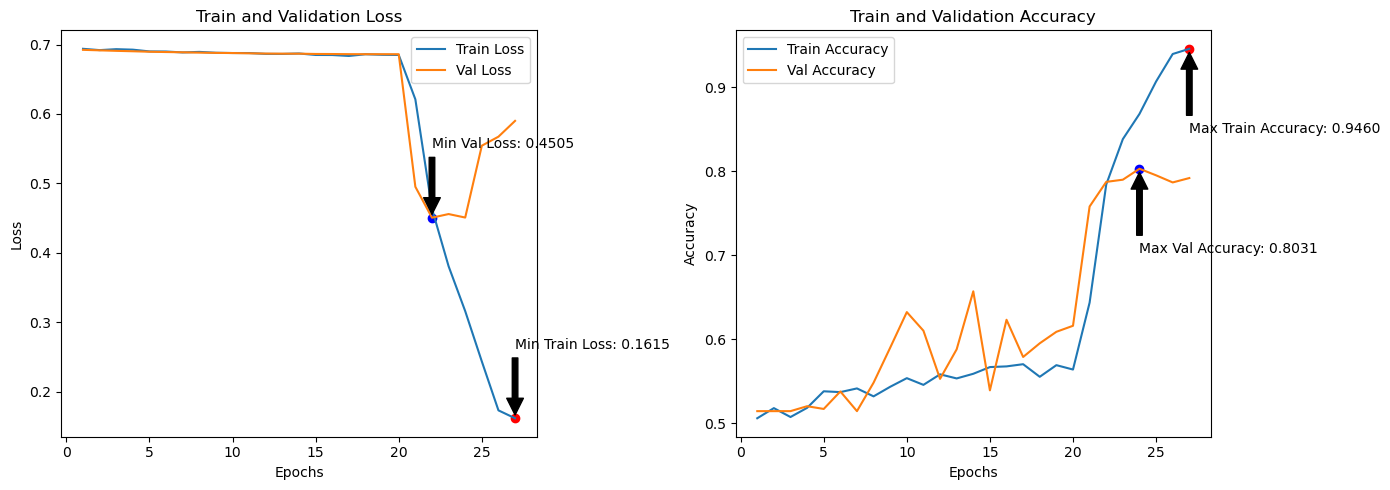

In [14]:
import matplotlib.pyplot as plt

# Assuming the following lists contain the results of the initial training and fine-tuning phases
# Append the fine-tuning results to the initial results
train_losses = [0.6938737168287238, 0.6919840133438507, 0.6933590229600668, 0.6926402382863065, 0.6901048761792481, 0.6899727073808511, 0.688651493905733, 0.6894310656934977, 0.6881917618835965, 0.6877912801379958, 0.6877669336584707, 0.686543609170864, 0.6864683058423301, 0.6871209621119002, 0.6850001774728298, 0.6849100158239404, 0.683569438289851, 0.6860027518123388, 0.6852134632257124, 0.6849666043805579,
               0.6210686582683896, 0.46342602907679975, 0.38053192634833977, 0.3158080200276648, 0.243321116072669, 0.17281547098779507, 0.16145908435767828]
val_losses = [0.6923904990156492, 0.691653760150075, 0.6909415032714605, 0.6903301098694404, 0.6896525168170532, 0.6892230610052744, 0.688841956978043, 0.688330831627051, 0.6879863645881414, 0.6877710577100515, 0.6874008687833945, 0.6870048654576143, 0.68685166289409, 0.6868572824945053, 0.6864380656431118, 0.6863493627558152, 0.6861548783878485, 0.6861035215357939, 0.686080714687705, 0.6860784900685152,
              0.49503088106090826, 0.45051724432657164, 0.45572584549275535, 0.45070513306806487, 0.5542676160888126, 0.5672329225732634, 0.5900066578372692]
train_accuracies = [0.5058689272905119, 0.5179328333876753, 0.5073361591131399, 0.5182588849038148, 0.5379850016302575, 0.5370068470818389, 0.5414085425497228, 0.5319530485816759, 0.5433648516465601, 0.553635474404956, 0.545647212259537, 0.5582001956309097, 0.5533094228888165, 0.5588522986631888, 0.5668405608086078, 0.5676556895989566, 0.5702641017280731, 0.5552657319856538, 0.5691229214215846, 0.5639060971633518,
                    0.6436256928594718, 0.7843169220736876, 0.8384414737528529, 0.8684382132376915, 0.9070753179002282, 0.939843495272253, 0.9460384740789044]
val_accuracies = [0.5143415906127771, 0.5143415906127771, 0.5143415906127771, 0.5202086049543676, 0.5169491525423728, 0.5378096479791394, 0.5143415906127771, 0.5482398956975228, 0.589960886571056, 0.6323337679269883, 0.6101694915254237, 0.5528031290743155, 0.5880052151238592, 0.6571056062581486, 0.5391134289439374, 0.6232073011734028, 0.5788787483702738, 0.5951760104302477, 0.6088657105606258, 0.6160365058670143,
               0.758148631029987, 0.78748370273794, 0.7900912646675359, 0.803129074315515, 0.7953063885267275, 0.786831812255541, 0.7920469361147326]

# Create epochs list
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.scatter(epochs[train_losses.index(min(train_losses))], min(train_losses), color='red')  # Min Train Loss
plt.scatter(epochs[val_losses.index(min(val_losses))], min(val_losses), color='blue')  # Min Val Loss
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(f'Min Train Loss: {min(train_losses):.4f}', xy=(epochs[train_losses.index(min(train_losses))], min(train_losses)), xytext=(epochs[train_losses.index(min(train_losses))], min(train_losses) + 0.1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Min Val Loss: {min(val_losses):.4f}', xy=(epochs[val_losses.index(min(val_losses))], min(val_losses)), xytext=(epochs[val_losses.index(min(val_losses))], min(val_losses) + 0.1), arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.scatter(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies), color='red')  # Max Train Accuracy
plt.scatter(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies), color='blue')  # Max Val Accuracy
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate(f'Max Train Accuracy: {max(train_accuracies):.4f}', xy=(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies)), xytext=(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies) - 0.1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Max Val Accuracy: {max(val_accuracies):.4f}', xy=(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies)), xytext=(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies) - 0.1), arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()


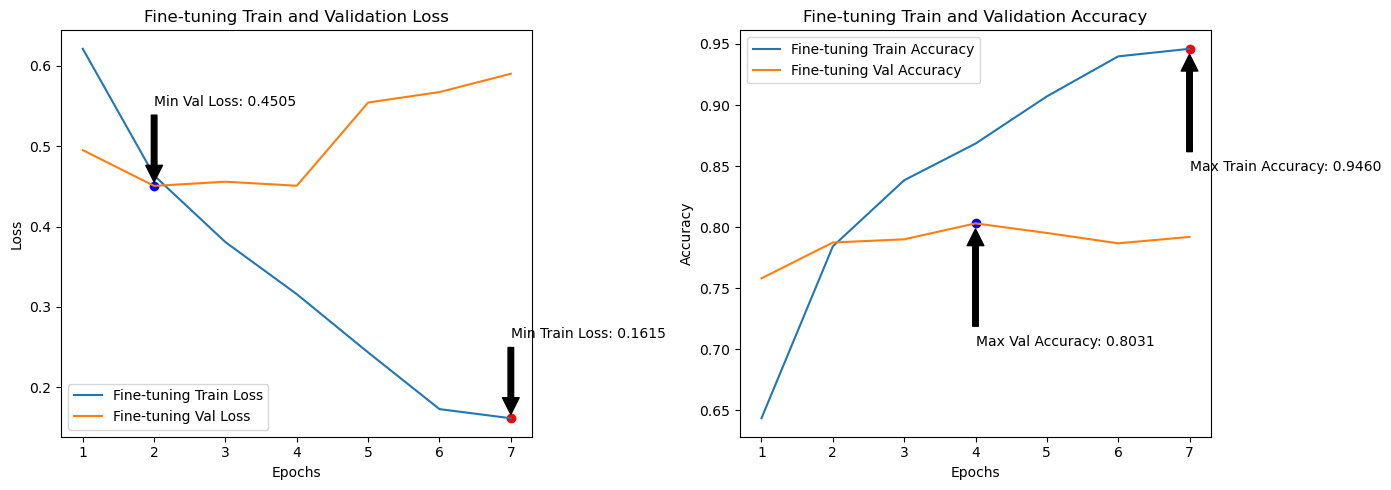

In [16]:
import matplotlib.pyplot as plt

# Fine-tuning results
fine_tune_train_losses = [0.6210686582683896, 0.46342602907679975, 0.38053192634833977, 0.3158080200276648, 0.243321116072669, 0.17281547098779507, 0.16145908435767828]
fine_tune_val_losses = [0.49503088106090826, 0.45051724432657164, 0.45572584549275535, 0.45070513306806487, 0.5542676160888126, 0.5672329225732634, 0.5900066578372692]
fine_tune_train_accuracies = [0.6436256928594718, 0.7843169220736876, 0.8384414737528529, 0.8684382132376915, 0.9070753179002282, 0.939843495272253, 0.9460384740789044]
fine_tune_val_accuracies = [0.758148631029987, 0.78748370273794, 0.7900912646675359, 0.803129074315515, 0.7953063885267275, 0.786831812255541, 0.7920469361147326]

fine_tune_epochs = range(1, len(fine_tune_train_losses) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(fine_tune_epochs, fine_tune_train_losses, label='Fine-tuning Train Loss')
plt.plot(fine_tune_epochs, fine_tune_val_losses, label='Fine-tuning Val Loss')
plt.scatter(fine_tune_epochs[fine_tune_train_losses.index(min(fine_tune_train_losses))], min(fine_tune_train_losses), color='red')  # Min Fine-tuning Train Loss
plt.scatter(fine_tune_epochs[fine_tune_val_losses.index(min(fine_tune_val_losses))], min(fine_tune_val_losses), color='blue')  # Min Fine-tuning Val Loss
plt.title('Fine-tuning Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(f'Min Train Loss: {min(fine_tune_train_losses):.4f}', xy=(fine_tune_epochs[fine_tune_train_losses.index(min(fine_tune_train_losses))], min(fine_tune_train_losses)), xytext=(fine_tune_epochs[fine_tune_train_losses.index(min(fine_tune_train_losses))], min(fine_tune_train_losses) + 0.1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Min Val Loss: {min(fine_tune_val_losses):.4f}', xy=(fine_tune_epochs[fine_tune_val_losses.index(min(fine_tune_val_losses))], min(fine_tune_val_losses)), xytext=(fine_tune_epochs[fine_tune_val_losses.index(min(fine_tune_val_losses))], min(fine_tune_val_losses) + 0.1), arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(1, 2, 2)
plt.plot(fine_tune_epochs, fine_tune_train_accuracies, label='Fine-tuning Train Accuracy')
plt.plot(fine_tune_epochs, fine_tune_val_accuracies, label='Fine-tuning Val Accuracy')
plt.scatter(fine_tune_epochs[fine_tune_train_accuracies.index(max(fine_tune_train_accuracies))], max(fine_tune_train_accuracies), color='red')  # Max Fine-tuning Train Accuracy
plt.scatter(fine_tune_epochs[fine_tune_val_accuracies.index(max(fine_tune_val_accuracies))], max(fine_tune_val_accuracies), color='blue')  # Max Fine-tuning Val Accuracy
plt.title('Fine-tuning Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate(f'Max Train Accuracy: {max(fine_tune_train_accuracies):.4f}', xy=(fine_tune_epochs[fine_tune_train_accuracies.index(max(fine_tune_train_accuracies))], max(fine_tune_train_accuracies)), xytext=(fine_tune_epochs[fine_tune_train_accuracies.index(max(fine_tune_train_accuracies))], max(fine_tune_train_accuracies) - 0.1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Max Val Accuracy: {max(fine_tune_val_accuracies):.4f}', xy=(fine_tune_epochs[fine_tune_val_accuracies.index(max(fine_tune_val_accuracies))], max(fine_tune_val_accuracies)), xytext=(fine_tune_epochs[fine_tune_val_accuracies.index(max(fine_tune_val_accuracies))], max(fine_tune_val_accuracies) - 0.1), arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()


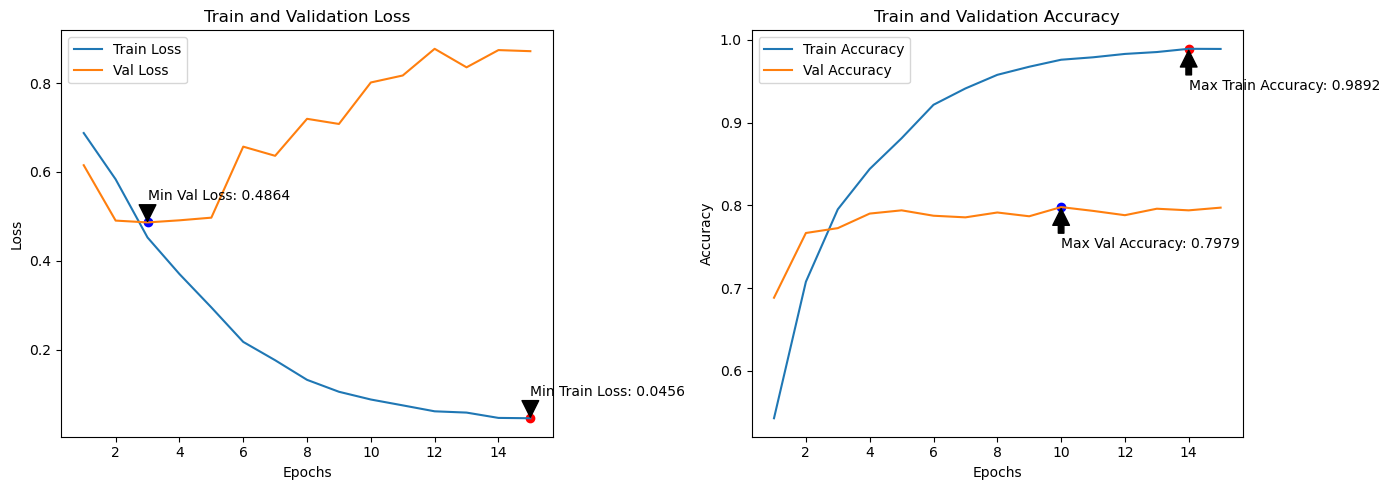

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame with the provided data
data = {
    'Epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'Train Loss': [0.6875362697367867, 0.5834171084376673, 0.4524518313507239, 0.370227088589066, 0.2951183402716803, 0.21746058956099054, 0.17621038878375353, 0.13208831709440952, 0.10523020628897939, 0.08780347168794833, 0.07462648944783723, 0.06124378448779074, 0.058369541062954035, 0.04639962160520857, 0.04562964315300633],
    'Val Loss': [0.615106076002121, 0.4904790630874534, 0.4863950641204913, 0.4910891615630438, 0.4970789106252293, 0.6569169124704786, 0.6362665991376465, 0.7195282744942233, 0.7079749808569128, 0.8013379509211518, 0.8170473838302618, 0.8771039830559554, 0.835421774458761, 0.8742152467990915, 0.8717554394388571],
    'Train Accuracy': [0.5427127486142811, 0.7076948157808933, 0.7952396478643625, 0.8439843495272253, 0.881154222367134, 0.9215846103684382, 0.941310727094881, 0.9577763286599282, 0.9675578741441148, 0.976035213563743, 0.978969677208999, 0.9830453211607434, 0.9853276817737202, 0.9892402999673948, 0.989077274209325],
    'Val Accuracy': [0.6883963494132985, 0.7666232073011734, 0.772490221642764, 0.7900912646675359, 0.7940026075619295, 0.78748370273794, 0.7855280312907431, 0.7913950456323338, 0.786831812255541, 0.7979139504563233, 0.7933507170795306, 0.788135593220339, 0.7959582790091264, 0.7940026075619295, 0.7972620599739244]
}

df = pd.DataFrame(data)

# Plotting the results
epochs = df['Epoch']

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, df['Train Loss'], label='Train Loss')
plt.plot(epochs, df['Val Loss'], label='Val Loss')
plt.scatter(epochs[df['Val Loss'].idxmin()], df['Val Loss'].min(), color='blue')  # Min Val Loss
plt.scatter(epochs[df['Train Loss'].idxmin()], df['Train Loss'].min(), color='red')  # Min Train Loss
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(f'Min Train Loss: {df["Train Loss"].min():.4f}', xy=(epochs[df['Train Loss'].idxmin()], df['Train Loss'].min()), xytext=(epochs[df['Train Loss'].idxmin()], df['Train Loss'].min() + 0.05), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Min Val Loss: {df["Val Loss"].min():.4f}', xy=(epochs[df['Val Loss'].idxmin()], df['Val Loss'].min()), xytext=(epochs[df['Val Loss'].idxmin()], df['Val Loss'].min() + 0.05), arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(1, 2, 2)
plt.plot(epochs, df['Train Accuracy'], label='Train Accuracy')
plt.plot(epochs, df['Val Accuracy'], label='Val Accuracy')
plt.scatter(epochs[df['Val Accuracy'].idxmax()], df['Val Accuracy'].max(), color='blue')  # Max Val Accuracy
plt.scatter(epochs[df['Train Accuracy'].idxmax()], df['Train Accuracy'].max(), color='red')  # Max Train Accuracy
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate(f'Max Train Accuracy: {df["Train Accuracy"].max():.4f}', xy=(epochs[df['Train Accuracy'].idxmax()], df['Train Accuracy'].max()), xytext=(epochs[df['Train Accuracy'].idxmax()], df['Train Accuracy'].max() - 0.05), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Max Val Accuracy: {df["Val Accuracy"].max():.4f}', xy=(epochs[df['Val Accuracy'].idxmax()], df['Val Accuracy'].max()), xytext=(epochs[df['Val Accuracy'].idxmax()], df['Val Accuracy'].max() - 0.05), arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()


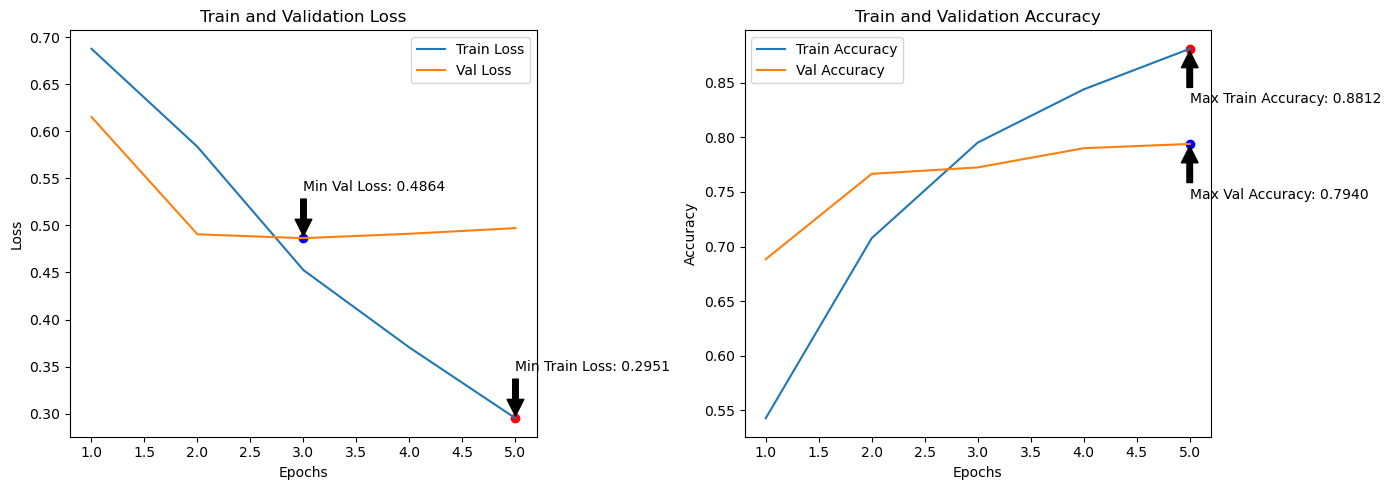

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame with the provided data up to epoch 5
data = {
    'Epoch': [1, 2, 3, 4, 5],
    'Train Loss': [0.6875362697367867, 0.5834171084376673, 0.4524518313507239, 0.370227088589066, 0.2951183402716803],
    'Val Loss': [0.615106076002121, 0.4904790630874534, 0.4863950641204913, 0.4910891615630438, 0.4970789106252293],
    'Train Accuracy': [0.5427127486142811, 0.7076948157808933, 0.7952396478643625, 0.8439843495272253, 0.881154222367134],
    'Val Accuracy': [0.6883963494132985, 0.7666232073011734, 0.772490221642764, 0.7900912646675359, 0.7940026075619295]
}

df = pd.DataFrame(data)

# Plotting the results
epochs = df['Epoch']

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, df['Train Loss'], label='Train Loss')
plt.plot(epochs, df['Val Loss'], label='Val Loss')
plt.scatter(epochs[df['Val Loss'].idxmin()], df['Val Loss'].min(), color='blue')  # Min Val Loss
plt.scatter(epochs[df['Train Loss'].idxmin()], df['Train Loss'].min(), color='red')  # Min Train Loss
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(f'Min Train Loss: {df["Train Loss"].min():.4f}', xy=(epochs[df['Train Loss'].idxmin()], df['Train Loss'].min()), xytext=(epochs[df['Train Loss'].idxmin()], df['Train Loss'].min() + 0.05), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Min Val Loss: {df["Val Loss"].min():.4f}', xy=(epochs[df['Val Loss'].idxmin()], df['Val Loss'].min()), xytext=(epochs[df['Val Loss'].idxmin()], df['Val Loss'].min() + 0.05), arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(1, 2, 2)
plt.plot(epochs, df['Train Accuracy'], label='Train Accuracy')
plt.plot(epochs, df['Val Accuracy'], label='Val Accuracy')
plt.scatter(epochs[df['Val Accuracy'].idxmax()], df['Val Accuracy'].max(), color='blue')  # Max Val Accuracy
plt.scatter(epochs[df['Train Accuracy'].idxmax()], df['Train Accuracy'].max(), color='red')  # Max Train Accuracy
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate(f'Max Train Accuracy: {df["Train Accuracy"].max():.4f}', xy=(epochs[df['Train Accuracy'].idxmax()], df['Train Accuracy'].max()), xytext=(epochs[df['Train Accuracy'].idxmax()], df['Train Accuracy'].max() - 0.05), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Max Val Accuracy: {df["Val Accuracy"].max():.4f}', xy=(epochs[df['Val Accuracy'].idxmax()], df['Val Accuracy'].max()), xytext=(epochs[df['Val Accuracy'].idxmax()], df['Val Accuracy'].max() - 0.05), arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()


In [21]:
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np

# Install SentencePiece if not already installed
try:
    import sentencepiece
except ImportError:
    !pip install sentencepiece
    import sentencepiece

# Load the training/validation dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Load the pre-trained XLM-Roberta model and tokenizer
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 15  # Increased number of epochs
LEARNING_RATE = 2e-5  # Experiment with a different learning rate

# Split the dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Tweets'], df['label'], test_size=0.2, random_state=42)

# Reset index to avoid KeyError issues
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 15)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')

# Save the trained model and tokenizer
model.save_pretrained('xlm_roberta')
tokenizer.save_pretrained('new_tokenizer_roberta')


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/15
---------------
Train loss 0.6942318974373242 accuracy 0.5088033909357679
Val   loss 0.6924744260807832 accuracy 0.5143415906127771
Epoch 2/15
---------------
Train loss 0.6962186197439829 accuracy 0.5099445712422562
Val   loss 0.6894692828257879 accuracy 0.5136897001303781
Epoch 3/15
---------------
Train loss 0.6819752475712448 accuracy 0.5616237365503749
Val   loss 0.6905039461950461 accuracy 0.499348109517601
Epoch 4/15
---------------
Train loss 0.6579039044833431 accuracy 0.6033583306162373
Val   loss 0.6933715318640074 accuracy 0.48565840938722293
Epoch 5/15
---------------
Train loss 0.6959272768969337 accuracy 0.49625040756439515
Val   loss 0.692770371834437 accuracy 0.5143415906127771
Epoch 6/15
---------------
Train loss 0.6960249183078607 accuracy 0.49625040756439515
Val   loss 0.6953894098599752 accuracy 0.48565840938722293
Epoch 7/15
---------------


KeyboardInterrupt: 

In [22]:
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np

# Install SentencePiece if not already installed
try:
    import sentencepiece
except ImportError:
    !pip install sentencepiece
    import sentencepiece

# Load the training/validation dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Load the pre-trained XLM-Roberta model and tokenizer
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 2e-5  # Try a smaller learning rate
WEIGHT_DECAY = 0.01

# Split the dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Tweets'], df['label'], test_size=0.2, random_state=42)

# Reset index to avoid KeyError issues
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer and scheduler with weight decay for regularization
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

# Implement early stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.best_score = -val_loss

early_stopping = EarlyStopping(patience=3, verbose=True)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Save the best model and tokenizer
model.load_state_dict(torch.load('checkpoint.pt'))
model.save_pretrained('xlm_roberta')
tokenizer.save_pretrained('new_tokenizer_roberta')


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/15
----------


RuntimeError: CUDA out of memory. Tried to allocate 734.00 MiB (GPU 0; 15.77 GiB total capacity; 9.17 GiB already allocated; 625.12 MiB free; 9.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

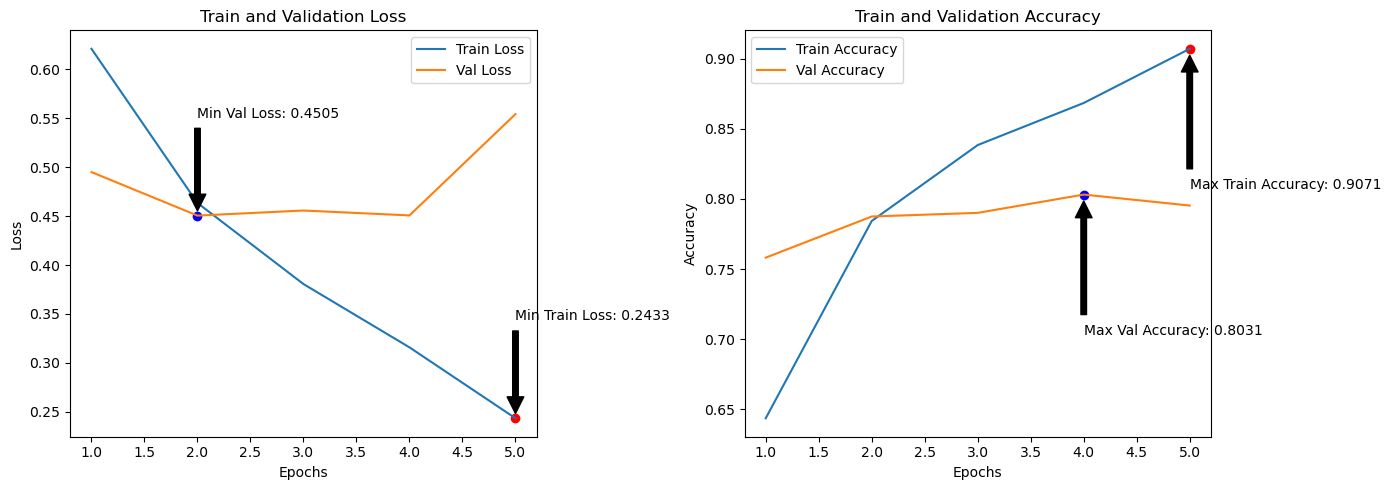

In [2]:
import matplotlib.pyplot as plt

# Given data up to epoch 5
train_losses = [0.6210686582683896, 0.46342602907679975, 0.38053192634833977, 0.3158080200276648, 0.243321116072669]
val_losses = [0.49503088106090826, 0.45051724432657164, 0.45572584549275535, 0.45070513306806487, 0.5542676160888126]
train_accuracies = [0.6436256928594718, 0.7843169220736876, 0.8384414737528529, 0.8684382132376915, 0.9070753179002282]
val_accuracies = [0.758148631029987, 0.78748370273794, 0.7900912646675359, 0.803129074315515, 0.7953063885267275]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.scatter(epochs[train_losses.index(min(train_losses))], min(train_losses), color='red')  # Min Train Loss
plt.scatter(epochs[val_losses.index(min(val_losses))], min(val_losses), color='blue')  # Min Val Loss
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(f'Min Train Loss: {min(train_losses):.4f}', xy=(epochs[train_losses.index(min(train_losses))], min(train_losses)), xytext=(epochs[train_losses.index(min(train_losses))], min(train_losses) + 0.1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Min Val Loss: {min(val_losses):.4f}', xy=(epochs[val_losses.index(min(val_losses))], min(val_losses)), xytext=(epochs[val_losses.index(min(val_losses))], min(val_losses) + 0.1), arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.scatter(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies), color='red')  # Max Train Accuracy
plt.scatter(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies), color='blue')  # Max Val Accuracy
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate(f'Max Train Accuracy: {max(train_accuracies):.4f}', xy=(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies)), xytext=(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies) - 0.1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Max Val Accuracy: {max(val_accuracies):.4f}', xy=(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies)), xytext=(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies) - 0.1), arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()
